# Simulation NMR spectra and comparison to experimental data

In this example, we calculate the <sup>1</sup>H-NMR spectrum of camphor similar to the [third tutorial](./3_customization.ipynb) and compare it with available experimental data.

## Technical details

### Package import

In [1]:
# General packages
from copy import deepcopy
from IPython.display import SVG, display  # noqa: A004
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from rdkit import Chem
from shutil import copy
from typing import Optional

In [2]:
# HQS NMR packages
from hqs_nmr_parameters import MolecularData, read_parameters_yaml
from hqs_nmr_parameters.examples import molecules as dataset_molecules

from hqs_nmr import conversion
from hqs_nmr.calculate import calculate_spectrum
from hqs_nmr.datatypes import (
    NMRCalculationParameters,
    NMRResultSpectrum1D,
    NMRSolverSettings,
    to_json,
)
from hqs_nmr.spectrumio import read_bruker_dir, write_jdx
from hqs_nmr.visualization import plot_spectra, maximum_excluding_region

### Helper functions

Here we will introduce some utilities that can help us work with molecular data and perform our simulations, taking into account the knowledge acquired in the previous tutorials.

#### Helper function to obtain a molecular data object

In **HQS Spectrum Tools**, we accepts three formats to input molecular data.
- If the molecule of interest belongs to the `hqs-nmr-parameters` package, we can access it via its `key` as shown in the [third tutorial](./3_customization.ipynb).
- `YAML` file with the molecule parameters (see [first tutorial](./1_getting_started.ipynb)). If the `YAML` file specifies a `Molfile` as molecular structure, it must be present in the working folder.
- A `JSON` file with the molecule parameters (serialization of a `MolecularData` object, see details in [documentation](https://docs.cloud.quantumsimulations.de/hqs-spectrum-tools/subfolder/database/molecular_data.html#serialization-saving-in-a-json-file-of-a-moleculardata-object-and-deserialization)).

The function `get_molecular_data` accepts as argument a string containing a file name without extension or a molecule `key` and returns a `MolecularData` object.

In [3]:
def get_molecular_data(base_name: str) -> MolecularData:
    """Return a MolecularData object.

    Args:
        base_name:  Name of the molecular data file (without suffix) or
                    key (entry in hqs-name-parameters).

    Raises:
        KeyError: If the molecule is not found in the database.

    Returns:
        A MolecularData object.
    """
    # Reading molecule parameters from YAML file, JSON file (`MolecularData`)
    # or hqs_nmr_parameters repository
    yaml_mol_file = Path(f"{base_name:s}.yaml")
    json_mol_file = Path(f"{base_name:s}.json")
    if yaml_mol_file.exists():
        # Reading from a local YAML file
        molecule = read_parameters_yaml(yaml_mol_file)
    elif json_mol_file.exists():
        molecule = MolecularData.read_file(json_mol_file)
    else:
        # Reading from database
        if base_name in dataset_molecules.get_keys():
            molecule = dataset_molecules[base_name]
        else:
            raise KeyError(
                f"Molecule '{base_name:s}' not found in the dataset. "
                "Try `dataset_molecules.get_keys()` to get a list of valid molecule keys."
            )
    return molecule

#### Helper function for drawing a two-dimensional structure

This function can help to check the structure of the molecule of interest. For that we make use of a external package called [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html).

In [4]:
def draw_2d_structure(molecule: MolecularData) -> None:
    """Function to draw a two-dimensional molecular structure using RDKit.

    Args:
        molecule:   A MolecularData object.

    Raises:
        ValueError: RDKit support Molfiles or SMILES strings.
    """

    # Get molecule structure and draw it using RDKit if Molfile or SMILES string is available.
    if molecule.structures.get("Molfile"):
        mol_string = molecule.structures["Molfile"].content
        molecule_image_info = Chem.MolFromMolBlock(mol_string)
        Chem.Draw.MolToImage(molecule_image_info)
    elif molecule.structures.get("SMILES"):
        smiles_string = molecule.structures["SMILES"].content
        molecule_image_info = Chem.MolFromSmiles(smiles_string)
        Chem.Draw.MolToImage(molecule_image_info)
    else:
        raise ValueError(
            "RDKit only supports 2-dimensional representations (Molfiles or SMILES strings)."
        )

    d2d = Chem.Draw.rdMolDraw2D.MolDraw2DSVG(300, 300)
    d2d.DrawMolecule(molecule_image_info)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))

#### Helper functions to calculate a <sup>1</sup>H-NMR spectrum of a given molecule

The function `get_proton_spectrum` accepts as argument a `MolecularData` object. To custom the calculations,
we can provide the spectrometer frequency `frequency_MHz`, broadening of the peaks (`fwhm_Hz`) and the maximum cluster size (`max_cluster_size`) to be used within the spin dependent clustering solver implemented in **HQS Spectrum Tools**. Results, a instance of `NMRResultSpectrum1D`, can be stored in a `JSON` file (`store_results_json` file name).

In [5]:
def get_proton_spectrum(
    molecule: MolecularData,
    frequency_MHz: float = 400.0,
    max_cluster_size: int = 12,
    fwhm_Hz: Optional[float] = None,
    store_results_json: Optional[Path | str] = None,
) -> NMRResultSpectrum1D:
    """Calculate the 1H-NMR spectrum for a given molecule.

    Args:
        molecule:           A MolecularData object.
        frequency_MHz:      Spectrometer frequency in MHz. Defaults to 400 MHz.
        max_cluster_size:   Maximum size a cluster of spins (i.e., protons) is allowed to have.
                            Defaults to 12.
        fwhm_Hz:            Full width at half maximum (FWHM) height in Hz. If None (default), the
                            solver will choose a broadening based on the J-coupling values of the
                            molecule.
        store_results_json: A file name with extension (.json) can be provided. If provided, the
                            results will be saved in a JSON file.

    Returns:
        The result of the NMR spectrum calculation.
    """
    # Read calculation settings and parameters
    field_T = conversion.frequency_MHz_to_field_T(frequency_MHz)
    solver_settings = NMRSolverSettings(max_cluster_size=max_cluster_size)
    calculation_parameters = NMRCalculationParameters(
        field_T=field_T, fwhm_Hz=fwhm_Hz, solver_settings=solver_settings
    )

    # Calculate NMR spectrum
    result_spectrum = calculate_spectrum(molecule, calculation_parameters)

    # Store results in JSON file if required
    if store_results_json is not None and not Path(store_results_json).exists():
        to_json(result_spectrum, store_results_json)
    if store_results_json is not None and Path(store_results_json).exists():
        store_old_file = Path(store_results_json).stem + ".json.1"
        copy(store_results_json, store_old_file)
        to_json(result_spectrum, store_results_json)

    return result_spectrum

 As mentioned above, the simulated spectrum is stored as a `NMRResultSpectrum1D` Pydantic object. It contains information of the spectrum but also of the NMR parameters and calculation settings. We can re-use it to get a refined spectrum in a specific frequency window:

In [6]:
def refine_proton_spectrum(
    result_spectrum: NMRResultSpectrum1D,
    frequency_window_ppm: tuple[float, float],
    number_omegas: int = 4000,
) -> NMRResultSpectrum1D:
    """Refine the 1H-NMR spectrum (4000 frequency points) within a specified frequency window.

    Args:
        result_spectrum:        The NMRResultSpectrum1D object.
        frequency_window_ppm:   A tuple of two floats representing the lower and upper bounds of
                                the frequency window in ppm.
        number_omegas:          Number of frequency points to compute. Defaults to 4000.

    Returns:
        The result of the NMR spectrum calculation focuses on a specific area and computed
        with more frequency points.
    """
    calculation_parameters_mod = deepcopy(result_spectrum.calculation_parameters)
    calculation_parameters_mod.frequency_window_ppm = frequency_window_ppm
    calculation_parameters_mod.number_omegas = number_omegas
    result_spectrum_zoom = calculate_spectrum(
        result_spectrum.molecule_parameters, calculation_parameters_mod
    )
    return result_spectrum_zoom

## Spectra calculation and comparison to experimental data

### Camphor: theoretical NMR parameters

In this example, we calculate the <sup>1</sup>H-NMR spectrum of camphor using fully theoretical parameters and compare it with available experimental data.

- We will read the molecule parameters stored in `hqs_nmr_parameters`.
- Experimental data can be found in the BMRB database (entry [bmse001230](https://doi.org/10.13018/BMSE001230)). We have already downloaded and selected the data. A Bruker directory can be found here.
- In order to compare the simulated and experimental spectra, we should simulate the spectrum for similar conditions. <sup>1</sup>H-NMR experimental spectrum was recorded in chloroform at 500 MHz.

#### Reading the stored molecular data and drawing the structure

Let us import camphor from `dataset_molecules` and check the details of the stored data. As we can see in the `description` field of the `MolecularData` object, we have access to theoretical <sup>1</sup>H NMR parameters for camphor in chloroform.

In [7]:
base_name = "camphor_DFT"
molecule = get_molecular_data(base_name)

In [8]:
# Check details of the calculations
print(molecule.description)

1H parameters for camphor obtained via DFT calculations.
Optimizations at B97-3c/CPCM(chloroform).
Shifts with DSD-PBEP86-D3/pcSseg-3 (vs. TMS).
J-couplings with TPSS/pcJ-3 in vacuum.
Averaging 27 rotamers.



We can draw the two-dimensional structure of camphor using the helper function defined above.

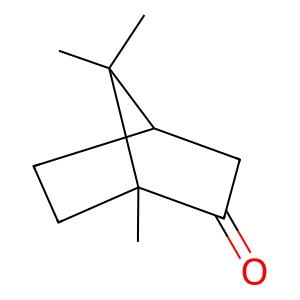

In [9]:
draw_2d_structure(molecule)

#### Simulating the HQS-NMR spectrum

Now, we are ready to calculate the NMR spectrum at 500 MHz with a maximum cluster size of 8 as recommended in the [third tutorial](./3_customization.ipynb), and with a custom broadening.

In [10]:
spectrometer_frequency_MHz = 500
broadening_Hz = 0.8
max_cluster_size = 8

result_spectrum = get_proton_spectrum(
    molecule,
    frequency_MHz=spectrometer_frequency_MHz,
    fwhm_Hz=broadening_Hz,
    max_cluster_size=max_cluster_size,
)

#### Processing experimental data

The next step is to read the experimental data. We have two options for that:
1. Read processed Bruker files from a directory using the `read_bruker_dir` function. This function requires the directory path where the binary files are stored. As optional arguments we have `source` and `license_id` in case we know the owner (or producer) of the spectrum and the license associated to it.
2. Read JCAMP-DX files (`.jdx`) using the `read_jdx` function. This function requires the file path to the JCAMP-DX file and optional arguments for the `source` and `license_id`. 
    - The current version of this function is designed to read only one block of data, i.e., one spectrum and one isotope.
    - In addition, we only support the `XYDATA` format, using as variable list evenly spaced x-values (`(X++(Y..Y)` format) or XY pairs of data points (`(XY..XY)` format).

Both functions return an instance of the `NMRExperimentalSpectrum1D` Pydantic class, which contains the spectrum data and some important information related to the experiment.

In [11]:
# For camphor, the experimental data is in a Bruker directory
path_bmrb = "./bruker_bmse001230/pdata/1"
experimental = read_bruker_dir(path_bmrb)

print(
    f"{type(experimental).__name__} object content: {', '.join(experimental.model_dump().keys())}"
)

NMRExperimentalSpectrum1D object content: frequency_MHz, omegas_ppm, intensity, solvent, temperature, isotope, source, license


#### Comparing spectra

Finally, we can compare the simulated and experimental spectra making use of the `plot_spectra` function:
 - It accepts as mandatory arguments the `simulated` spectrum (an `NMRSpectrum1D` object) and the `experimental` spectrum (an `NMRExperimentalSpectrum1D` object). 
 - One can also provide the x-axis range in ppm (`left` and `right` with the lower chemical shifts placed by convention at the `right` part of the spectrum).
 - `exclude` area: By default the plotted spectra will be normalized such that the maximum intensity is equal to one. If in the experiment the solvent peak has the highest intensity, the normalization will be wrong. Therefore, we can `exclude` this area from that process by indicating a tuple with two ppm values.
- `ax`: The spectra will be drawn in the specified Matplotlib axes (advanced option).
- `scale_experimental`: It defines the scaling mode for the experimental spectrum. It accepts tree different entries.
    - `max-intensity` rescales the experimental spectrum so that the largest intensity value is equal to one (default).
    - `max-intensity-window` rescales the experimental spectrum so that the largest intensity value within the current viewport (defined by `left` and `right`) is equal to one.
    - `factor` rescales the experimental spectrum with respect to the given scaling factor (`scale_experimental_factor` argument). Advanced option.

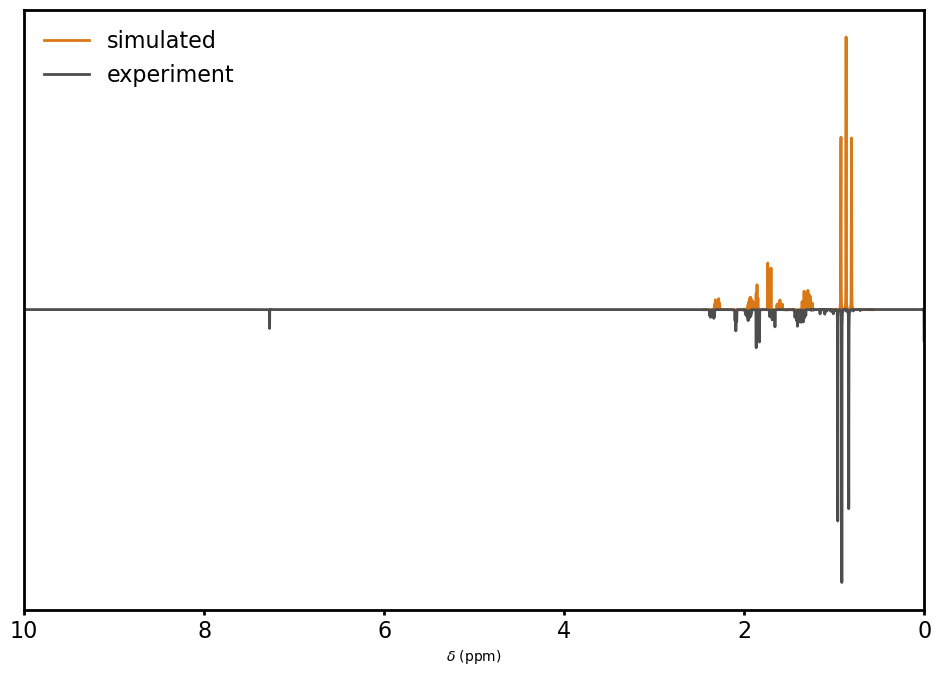

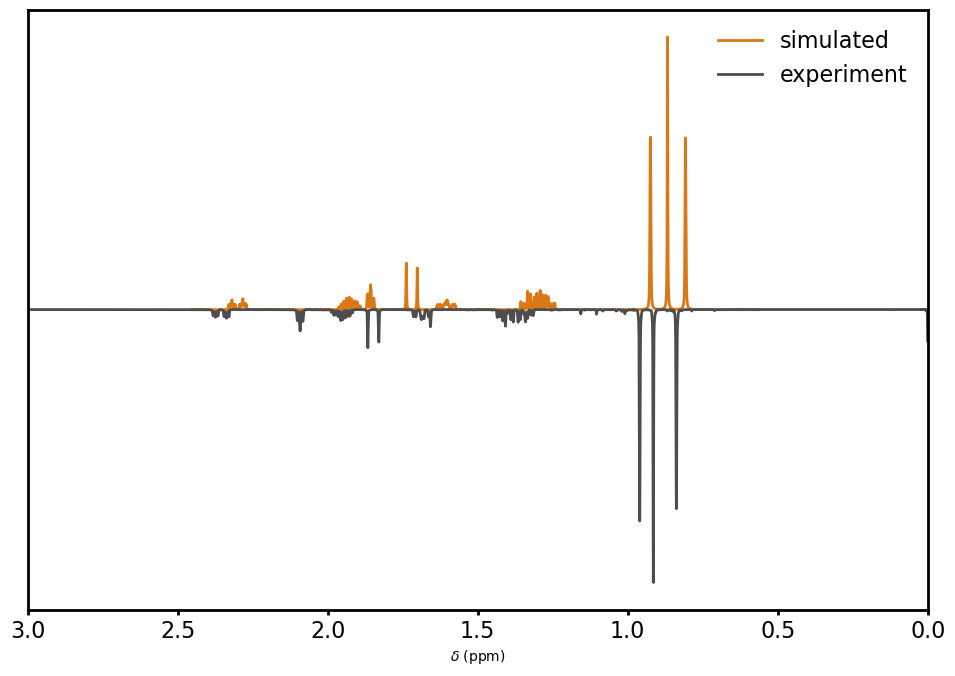

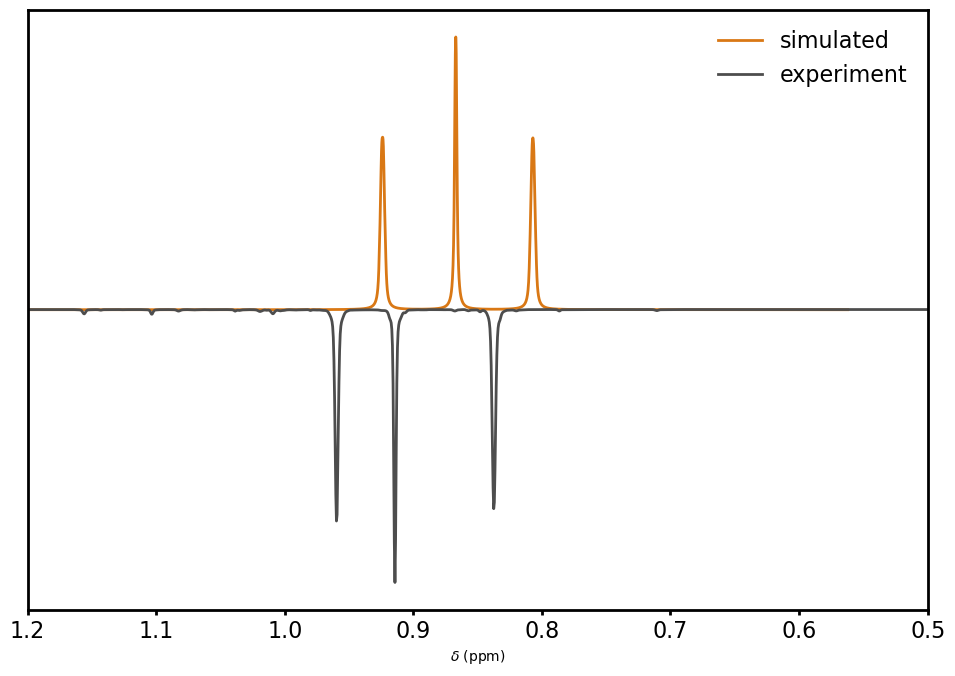

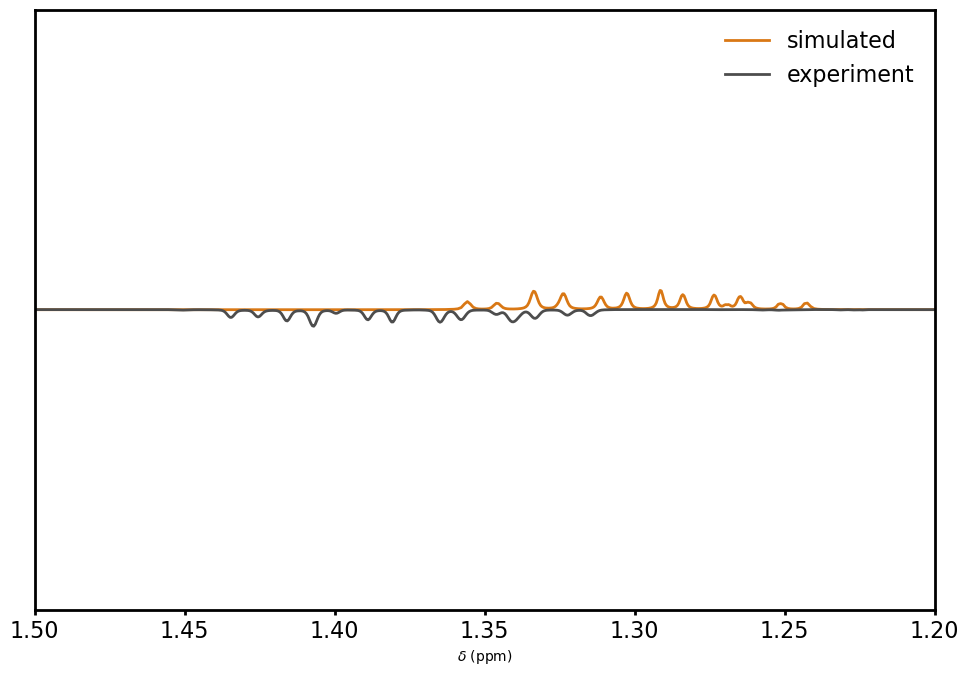

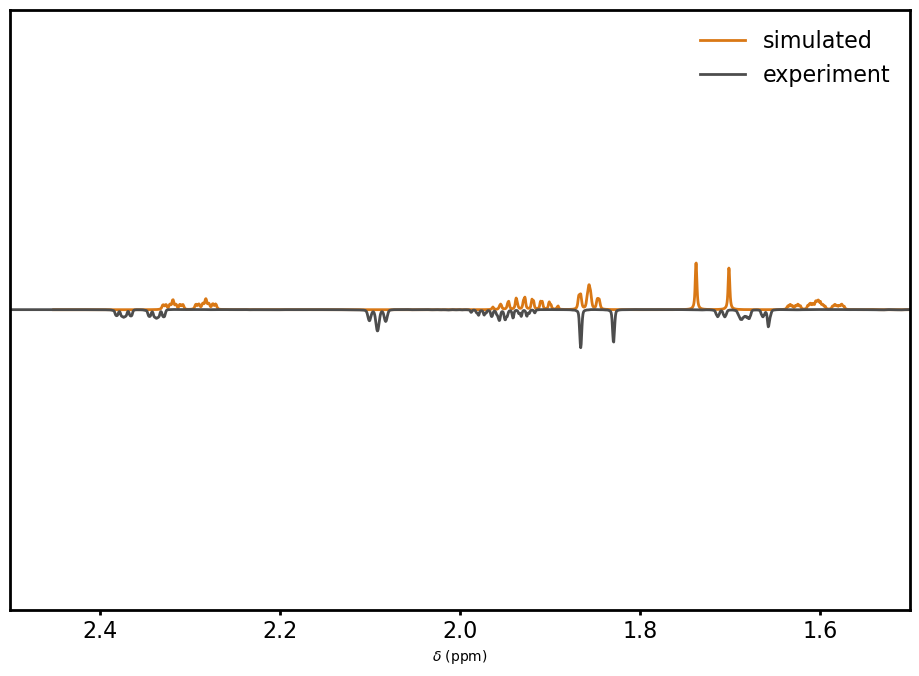

In [12]:
plot_spectra(result_spectrum.spectrum, experimental)
plot_spectra(result_spectrum.spectrum, experimental, left=3.0, right=0.0)
plot_spectra(result_spectrum.spectrum, experimental, left=1.2, right=0.5)
plot_spectra(result_spectrum.spectrum, experimental, left=1.5, right=1.2)
plot_spectra(result_spectrum.spectrum, experimental, left=2.5, right=1.5)

As we mentioned in the [third tutorial](3_customization.ipynb), the position of the multiplet at 2.1 ppm is swapped in the simulation and appears at around 1.85 ppm. This difference in the chemical shift is within [DFT accuracy](https://www.mdpi.com/1420-3049/28/6/2449). However, we can see that most of the features (multiplet structure) are well reproduced in the simulation.

#### Writing experimental data to a JCAMP-DX file

The JCAMP-DX format is convenient for storing an NMR spectrum in a single file. The `hqs_nmr` package provides the `write_jdx` function to save the experimental spectrum as a `.jdx` file.

We can re-use most of the information stored in the `NMRExperimentalSpectrum1D` object. In addition, we have the optional field `manual_shift`  to move the entire spectrum by a chemical shift value (defaults to `None`). This is useful when the experimental spectrum is wrongly referenced. As we can see in the above plots the solvent peak appears at around 7.27 ppm, which is compatible with [tabulated values](https://pubs.acs.org/doi/10.1021/acs.oprd.5b00417) for chloroform, therefore, we save the original values.

In [13]:
write_jdx(
    x_data=experimental.omegas_ppm,
    y_data=experimental.intensity,
    frequency_MHz=experimental.frequency_MHz,
    molecule_name="camphor",
    isotope=str(experimental.isotope),
    solvent="CDCl3",
    manual_shift=None,
)

The file `camphor_1H_CDCl3_499.84MHz_original.jdx` is then created in the current working directory. It employs an `XYDATA` block with the `(XY..XY)` format, i.e. data points are written as XY pairs.

This tool can also be used with external data. You will need to provide the x-axis data array (with the higher chemical shifts in ppm as first values), y-axis data array (intensity), frequency of the spectrometer in MHz, molecule name, isotope (defaults to <sup>1</sup>H), and the solvent (defaults to CDCl<sub>3</sub>, an empty string can be also provided).

### Camphor: combined NMR parameters

A very accurate spectrum can be simulated by combining chemical shifts assigned from a high-field NMR spectrum of the same molecule with calculated *J*-couplings, which are normally not readily available from experimental data.

#### Fetching combined NMR parameters

In the aforementioned BMRB entry [bmse001230](https://doi.org/10.13018/BMSE001230), an assignment of camphor was made and the data was included in the `hqs-nmr-parameters` package. Let us have a look:

In [14]:
name_combined = "camphor_exp"
molecule_combined = get_molecular_data(name_combined)

# Check details of the entry
print(molecule_combined.description)

Parameters for camphor combining experimentally assigned shifts with calculated J-couplings.
Shifts from the assignment in https://doi.org/10.13018/BMSE001230.
Optimizations with B97-3c/CPCM(chloroform).
J-couplings with TPSS/pcJ-3 in vacuum.
Averaging 27 rotamers.



In [15]:
# Get experimental shifts
print(
    f"""Experimental shifts:
{', '.join(f"{s:.2f}" for s in molecule_combined.spin_system().shifts)}
"""
)

# Get Theoretical shifts
print(
    f"""Theoretical shifts:
{', '.join(f"{s:.2f}" for s in molecule.spin_system().shifts)}
"""
)

Experimental shifts:
1.41, 1.67, 1.34, 1.95, 2.35, 1.85, 2.09, 0.96, 0.96, 0.96, 0.84, 0.84, 0.84, 0.92, 0.92, 0.92

Theoretical shifts:
1.33, 1.60, 1.27, 1.93, 2.30, 1.72, 1.86, 0.81, 0.81, 0.81, 0.92, 0.92, 0.92, 0.87, 0.87, 0.87



#### Spectrum simulation and general comparison with experimental data

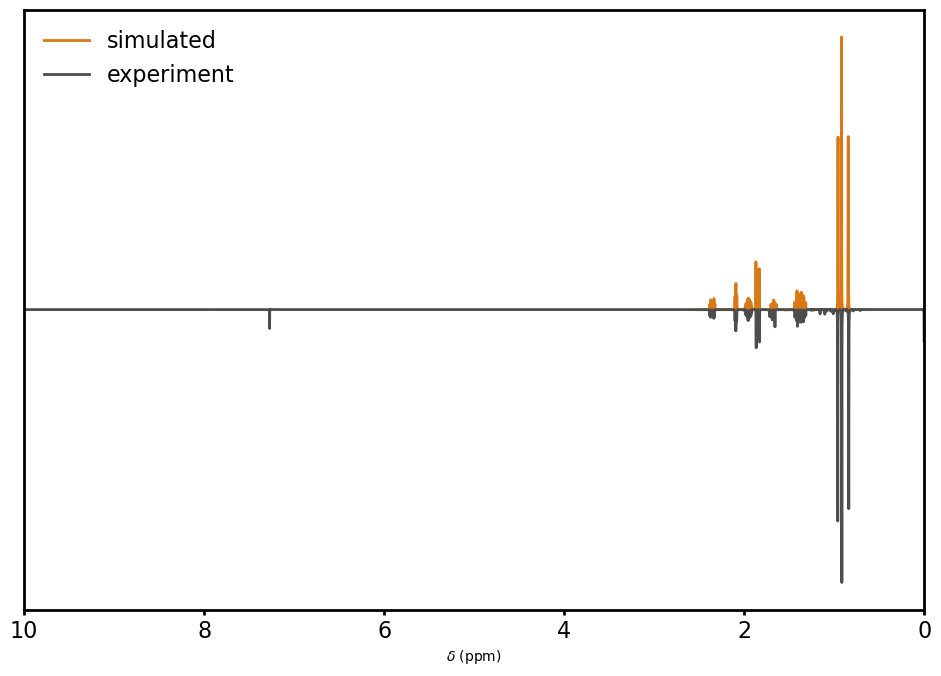

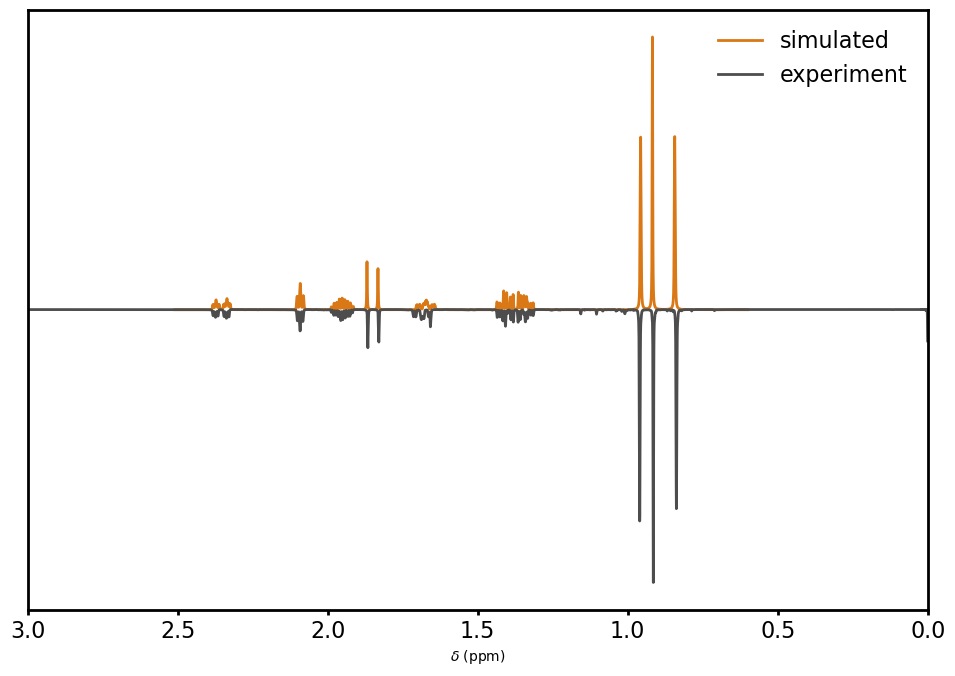

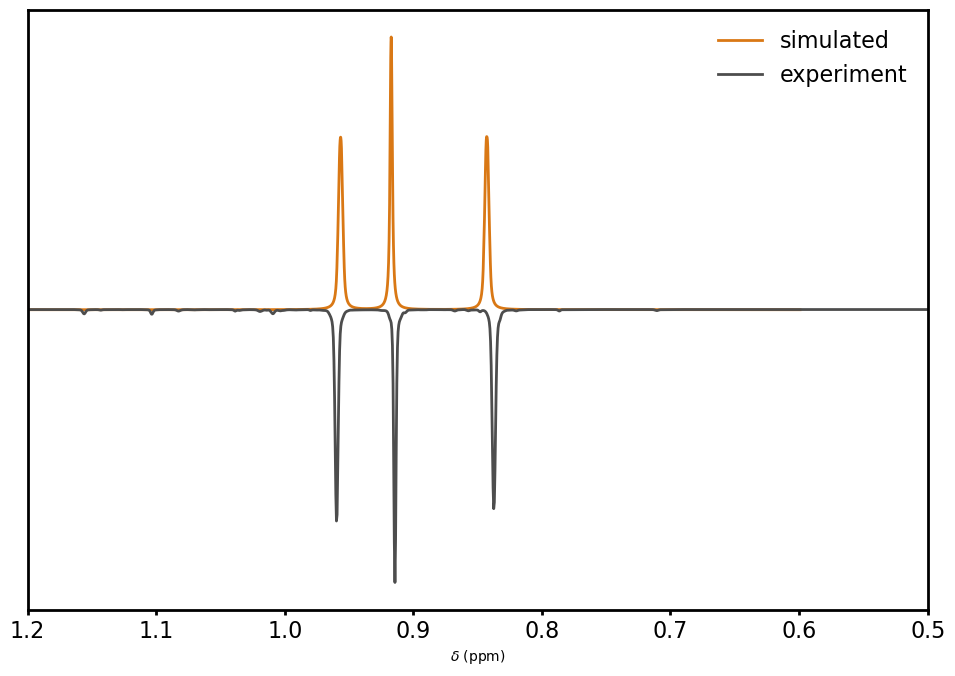

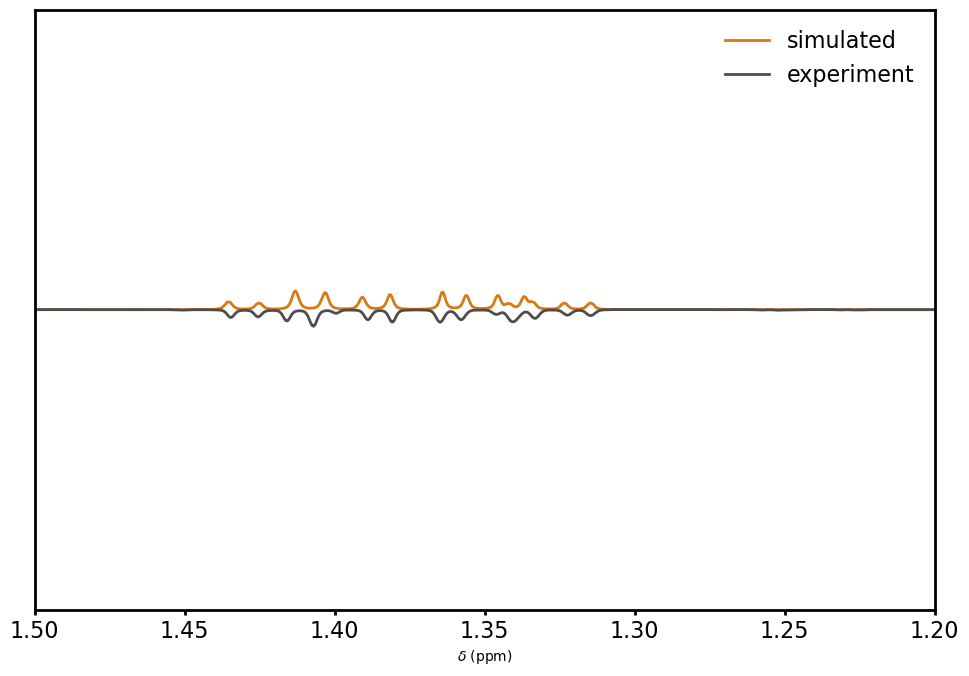

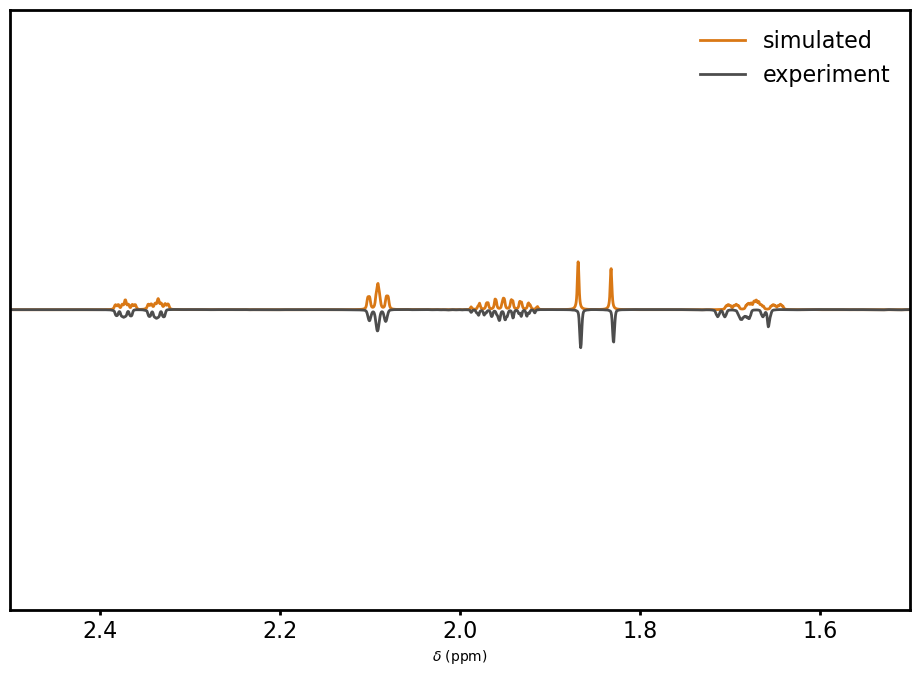

In [16]:
# Simulated HQS-NMR spectrum

spectrometer_frequency_MHz = 500
broadening_Hz = 0.8
max_cluster_size = 8

combined_spectrum = get_proton_spectrum(
    molecule_combined,
    frequency_MHz=spectrometer_frequency_MHz,
    fwhm_Hz=broadening_Hz,
    max_cluster_size=max_cluster_size,
)

plot_spectra(combined_spectrum.spectrum, experimental)
plot_spectra(combined_spectrum.spectrum, experimental, left=3.0, right=0.0)
plot_spectra(combined_spectrum.spectrum, experimental, left=1.2, right=0.5)
plot_spectra(combined_spectrum.spectrum, experimental, left=1.5, right=1.2)
plot_spectra(combined_spectrum.spectrum, experimental, left=2.5, right=1.5)

Now, the theoretical and experimental spectra match very well with the exception of the multiplet at around 1.67 ppm, that is slightly displaced.

#### Calculation of a refined <sup>1</sup>H NMR spectrum

Let us take a closer look at this multiplet belonging to the second proton (see list of shifts above), using the `refine_proton_spectrum` function:

In [17]:
frequency_window = (1.60, 1.75)

combined_spectrum_zoom = refine_proton_spectrum(
    combined_spectrum, frequency_window_ppm=frequency_window
)

For plotting, we will scale the experimental spectrum using the `max-intensity-window` option since we focus on a concrete part of the spectrum.

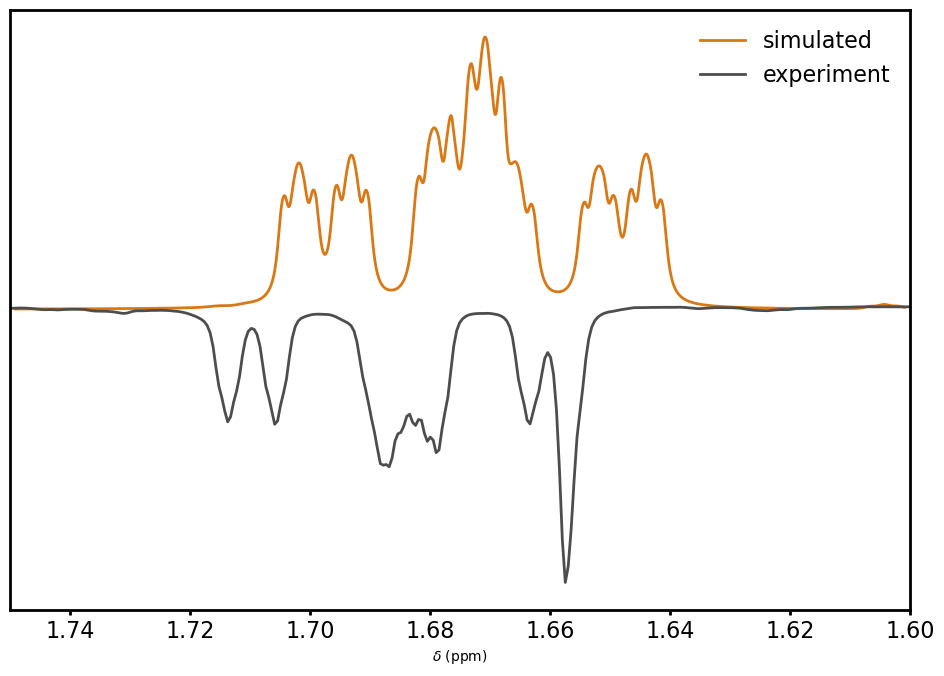

In [18]:
plot_spectra(
    combined_spectrum_zoom.spectrum,
    experimental,
    scale_experimental="max-intensity-window",
    left=frequency_window[1],
    right=frequency_window[0],
)

As we can see, the simulated multiplet has a complex coupling pattern and while the simulated signal is centered at 1.67 ppm, the experimental one is centered at around 1.68. If we pay attention to the splitting pattern of this atom, we can conclude that despite small differences, the base multiplet (doublet of doublets of doublets)  can be detected in both the simulated and experimental spectra.

In [19]:
# J-couplings involving the second spin (proton) of camphor:
spin = 1
for ele in molecule_combined.spin_system().j_couplings:
    if spin in ele[0]:
        print(f"J-coupling between atoms {ele[0][0]} and {ele[0][1]:2}: {ele[1]: 7.3f}")

J-coupling between atoms 0 and  1: -11.515
J-coupling between atoms 1 and  2:   4.673
J-coupling between atoms 1 and  3:  13.839
J-coupling between atoms 1 and  4:  -1.642
J-coupling between atoms 1 and  5:   0.333
J-coupling between atoms 1 and  6:   0.972
J-coupling between atoms 1 and  7:   0.000
J-coupling between atoms 1 and  8:   0.000
J-coupling between atoms 1 and  9:   0.000
J-coupling between atoms 1 and 10:  -0.037
J-coupling between atoms 1 and 11:  -0.037
J-coupling between atoms 1 and 12:  -0.037
J-coupling between atoms 1 and 13:  -0.062
J-coupling between atoms 1 and 14:  -0.062
J-coupling between atoms 1 and 15:  -0.062


### Final spectra comparison

To summarize our results, we can have a single plot comparing both simulated NMR spectra with the experimental one.

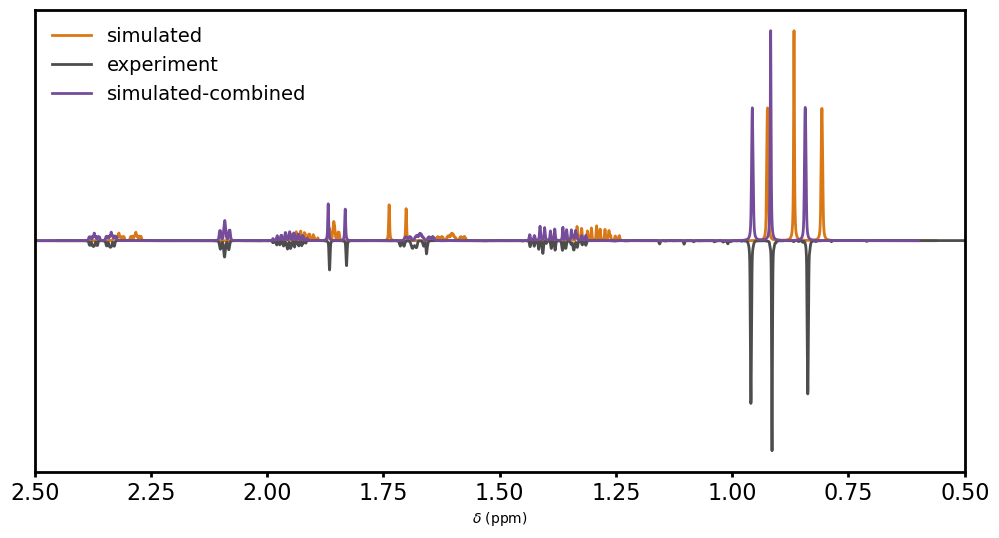

In [20]:
_, ax = plt.subplots(figsize=(12.0, 6.0))
plot_spectra(result_spectrum.spectrum, experimental, left=2.5, right=0.5, ax=ax)
y_combined = np.sum(combined_spectrum.spectrum.spin_contributions, axis=0)
ax.plot(
    combined_spectrum.spectrum.omegas_ppm,
    y_combined / maximum_excluding_region(combined_spectrum.spectrum.omegas_ppm, y_combined),
    color="#744C99",
    linewidth=2,
    label="simulated-combined",
)
ax.legend(loc="best", fontsize=14, frameon=False)